In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## import data

In [64]:
keras = tf.keras
tfds.disable_progress_bar()

# split the data manually into 80% training, 10% testing, 10% validation
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True,
)

In [ ]:
get_label_name = metadata.features["label"].int2str  # creates a function object that we can use to get labels

# display 5 images from the dataset
for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

## data preprocessing

In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/255)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  # also possible
  """
  image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # Resizing the image to 160x160 dimension
  return image, label
  """
  return image, label

# map images to 160x160
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

for image, label in train.take(5):
  plt.figure()
  plt.imshow(image)
  print(image.shape)
  plt.title(get_label_name(label))

In [ ]:
# use data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, label in raw_train.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    print(augmented_image.shape)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [72]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for img, label in raw_train.take(2):
  print("Original shape:", img.shape)

for img, label in train.take(2):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
Original shape: (409, 336, 3)
New shape: (160, 160, 3)
New shape: (160, 160, 3)


## pick pretrained model

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,  # don't include the classifier from this model
                                               weights="imagenet")  # predetermined weights from a google data 

# feature extractor converts each 160x160x3 image into a 5x5x1280 block of features                                               
base_model.summary()                                

In [17]:
# having 32 different layers of features
for image, _ in train_batches.take(1):
   pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Freezing the Base

In [ ]:
base_model.trainable = False
# no trainable para. anymore
base_model.summary()

## adding our classifier

In [ ]:
# flattens the (5, 5, 1280) tensor to a vector with 1280 elements
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# output layer
prediction_layer = keras.layers.Dense(1)

# create combined model
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

model.summary()

## train no augmentation

In [ ]:
base_learning_rate = 0.0001  # very small due to the cnn already in good shape
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [ ]:
# Now we can train it on our images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history["accuracy"]
(acc)

## train with augmentation
* ### not so good

In [ ]:
# with data augmentation
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)  # previous model overwritten

base_learning_rate = 0.0001  # very small due to the cnn already in good shape
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

In [80]:
acc = history.history["accuracy"]
(acc)

# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 9s 417ms/step - loss: 0.0649 - accuracy: 0.9797


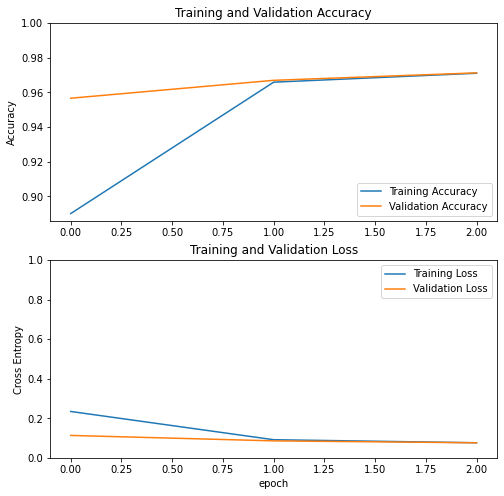

In [67]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## save and load model

In [ ]:
model.save("dog_vs_cat.h5")
new_model = tf.keras.models.load_model("dog_vs_cat.h5")

## fine tuning

In [81]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


## compile

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=["accuracy"])
model.summary()
len(model.trainable_variables)  # why 56, not 55?

## train

In [88]:
# this would take a hour
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 3/13
  9/582 [..............................] - ETA: 8:17 - loss: 0.1837 - accuracy: 0.9201

KeyboardInterrupt: ignored

## graph

In [89]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

NameError: ignored